In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt



2023-10-08 09:14:45.448461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:

df = pd.read_csv('data/powerball_cleaned_231007.csv')

# Now 'df' contains your data in a DataFrame


In [45]:
df.head()

,Draw Date,Wi,nni,ng,Num,ber,s
0,10/7/23,47,54,57,60,65,19
1,10/4/23,9,35,54,63,64,1
2,10/2/23,12,26,27,43,47,5
3,9/30/23,19,30,37,44,46,22
4,9/27/23,1,7,46,47,63,7


In [46]:


#rename columns
df = df.rename(columns={"Draw Date":"Date"})

#convert date to dt, refomat to yyyymmdd
df['Date'] = pd.to_datetime(df['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
df = df.reindex(index=df.index[::-1])

#set date as index
df.set_index('Date', inplace=True)

df.head()

,Wi,nni,ng,Num,ber,s
Date,,,,,,
2010-02-03,17,22,36,37,52,24
2010-02-06,14,22,52,54,59,4
2010-02-10,5,8,29,37,38,34
2010-02-13,10,14,30,40,51,1
2010-02-17,7,8,19,26,36,15


In [47]:
stacked_list = df.stack().tolist()

stacked_list[0:5]

[17, 22, 36, 37, 52]

In [48]:
numbers_df = pd.DataFrame(stacked_list, columns=["numbers"])

numbers_df.head()

,numbers
0,17
1,22
2,36
3,37
4,52


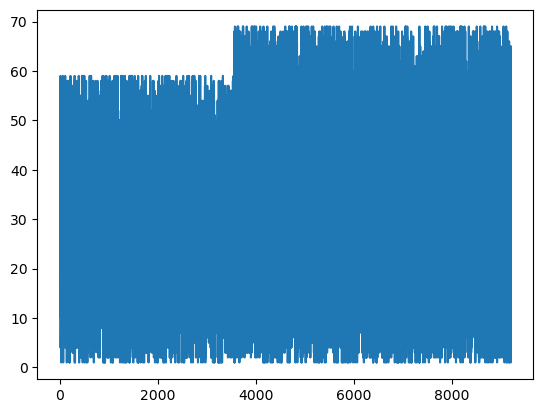

In [49]:
#plot historical amzn price
plt.plot(numbers_df)

In [50]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [51]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'numbers(t-{i})'] = data['numbers'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(numbers_df, lookback)

shifted_df.head()

,numbers,numbers(t-1),numbers(t-2),numbers(t-3),numbers(t-4),numbers(t-5),numbers(t-6),numbers(t-7)
7,22,14.0,24.0,52.0,37.0,36.0,22.0,17.0
8,52,22.0,14.0,24.0,52.0,37.0,36.0,22.0
9,54,52.0,22.0,14.0,24.0,52.0,37.0,36.0
10,59,54.0,52.0,22.0,14.0,24.0,52.0,37.0
11,4,59.0,54.0,52.0,22.0,14.0,24.0,52.0


In [52]:
shifted_df = shifted_df.astype(int)

shifted_df.head()

,numbers,numbers(t-1),numbers(t-2),numbers(t-3),numbers(t-4),numbers(t-5),numbers(t-6),numbers(t-7)
7,22,14,24,52,37,36,22,17
8,52,22,14,24,52,37,36,22
9,54,52,22,14,24,52,37,36
10,59,54,52,22,14,24,52,37
11,4,59,54,52,22,14,24,52


In [53]:
from sklearn.preprocessing import StandardScaler

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
# log_transformed_data = np.log(shifted_df_as_np)
# scaler = StandardScaler()

# scaled_data = scaler.fit_transform(shifted_df_as_np)


# split reference from deatures
X1 = shifted_df_as_np[:, 1:]
y1 = shifted_df_as_np[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((9191, 7), (9191,), (9191,))

In [54]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((7352, 7), (7352,), (919, 7), (919,), (920, 7), (920,))

In [55]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000)

Epoch 1/1000
230/230 [==============================] - 5s 9ms/step - loss: 325.4656 - mean_absolute_error: 13.9468 - val_loss: 86.3351 - val_mean_absolute_error: 7.4659
Epoch 2/1000
230/230 [==============================] - 2s 7ms/step - loss: 87.6183 - mean_absolute_error: 7.4313 - val_loss: 91.1324 - val_mean_absolute_error: 7.1868
Epoch 3/1000
230/230 [==============================] - 2s 7ms/step - loss: 83.8543 - mean_absolute_error: 7.1967 - val_loss: 77.3976 - val_mean_absolute_error: 7.0286
Epoch 4/1000
230/230 [==============================] - 2s 7ms/step - loss: 80.7795 - mean_absolute_error: 7.0861 - val_loss: 77.7150 - val_mean_absolute_error: 6.9939
Epoch 5/1000
230/230 [==============================] - 2s 7ms/step - loss: 80.5346 - mean_absolute_error: 7.0617 - val_loss: 76.3617 - val_mean_absolute_error: 7.0203
Epoch 6/1000
230/230 [==============================] - 2s 7ms/step - loss: 80.3861 - mean_absolute_error: 7.0702 - val_loss: 76.4362 - val_mean_absolute_erro

230/230 [==============================] - 1s 6ms/step - loss: 73.4114 - mean_absolute_error: 6.7704 - val_loss: 73.5756 - val_mean_absolute_error: 6.7723
Epoch 50/1000
230/230 [==============================] - 1s 6ms/step - loss: 75.6280 - mean_absolute_error: 6.8368 - val_loss: 79.5446 - val_mean_absolute_error: 6.9572
Epoch 51/1000
230/230 [==============================] - 1s 6ms/step - loss: 73.8706 - mean_absolute_error: 6.7808 - val_loss: 74.0422 - val_mean_absolute_error: 6.8995
Epoch 52/1000
230/230 [==============================] - 1s 6ms/step - loss: 75.6665 - mean_absolute_error: 6.8822 - val_loss: 85.7143 - val_mean_absolute_error: 7.1349
Epoch 53/1000
230/230 [==============================] - 1s 6ms/step - loss: 73.1956 - mean_absolute_error: 6.7413 - val_loss: 75.9433 - val_mean_absolute_error: 6.8167
Epoch 54/1000
230/230 [==============================] - 1s 6ms/step - loss: 72.9970 - mean_absolute_error: 6.7358 - val_loss: 78.1131 - val_mean_absolute_error: 7.0706


230/230 [==============================] - 1s 6ms/step - loss: 69.9301 - mean_absolute_error: 6.5941 - val_loss: 79.8762 - val_mean_absolute_error: 6.9725
Epoch 98/1000
230/230 [==============================] - 1s 6ms/step - loss: 68.1504 - mean_absolute_error: 6.4929 - val_loss: 80.2000 - val_mean_absolute_error: 7.1126
Epoch 99/1000
230/230 [==============================] - 1s 6ms/step - loss: 69.5870 - mean_absolute_error: 6.5518 - val_loss: 77.0359 - val_mean_absolute_error: 7.0918
Epoch 100/1000
230/230 [==============================] - 1s 6ms/step - loss: 68.3397 - mean_absolute_error: 6.5142 - val_loss: 77.3033 - val_mean_absolute_error: 6.9492
Epoch 101/1000
230/230 [==============================] - 1s 6ms/step - loss: 67.8739 - mean_absolute_error: 6.5011 - val_loss: 76.3909 - val_mean_absolute_error: 6.9084
Epoch 102/1000
230/230 [==============================] - 1s 6ms/step - loss: 69.3761 - mean_absolute_error: 6.5688 - val_loss: 76.6493 - val_mean_absolute_error: 6.93

230/230 [==============================] - 1s 6ms/step - loss: 58.4416 - mean_absolute_error: 5.9779 - val_loss: 87.6141 - val_mean_absolute_error: 7.3119
Epoch 146/1000
230/230 [==============================] - 1s 6ms/step - loss: 58.4508 - mean_absolute_error: 5.9679 - val_loss: 84.7787 - val_mean_absolute_error: 7.2003
Epoch 147/1000
230/230 [==============================] - 1s 6ms/step - loss: 56.9568 - mean_absolute_error: 5.9391 - val_loss: 89.9479 - val_mean_absolute_error: 7.4513
Epoch 148/1000
230/230 [==============================] - 1s 6ms/step - loss: 58.8941 - mean_absolute_error: 6.0301 - val_loss: 81.3137 - val_mean_absolute_error: 7.0455
Epoch 149/1000
230/230 [==============================] - 1s 6ms/step - loss: 56.9029 - mean_absolute_error: 5.9495 - val_loss: 85.0204 - val_mean_absolute_error: 7.0981
Epoch 150/1000
230/230 [==============================] - 1s 6ms/step - loss: 56.3008 - mean_absolute_error: 5.8808 - val_loss: 88.2847 - val_mean_absolute_error: 7.

230/230 [==============================] - 1s 6ms/step - loss: 44.3766 - mean_absolute_error: 5.1832 - val_loss: 99.1241 - val_mean_absolute_error: 7.6515
Epoch 194/1000
230/230 [==============================] - 1s 6ms/step - loss: 44.7489 - mean_absolute_error: 5.1919 - val_loss: 96.4053 - val_mean_absolute_error: 7.6255
Epoch 195/1000
230/230 [==============================] - 1s 6ms/step - loss: 43.3063 - mean_absolute_error: 5.0934 - val_loss: 96.9769 - val_mean_absolute_error: 7.6255
Epoch 196/1000
230/230 [==============================] - 1s 6ms/step - loss: 44.0692 - mean_absolute_error: 5.1618 - val_loss: 96.4512 - val_mean_absolute_error: 7.5244
Epoch 197/1000
230/230 [==============================] - 1s 6ms/step - loss: 42.7586 - mean_absolute_error: 5.0591 - val_loss: 96.6775 - val_mean_absolute_error: 7.5705
Epoch 198/1000
230/230 [==============================] - 1s 6ms/step - loss: 42.7114 - mean_absolute_error: 5.0565 - val_loss: 99.3442 - val_mean_absolute_error: 7.

230/230 [==============================] - 1s 6ms/step - loss: 31.8385 - mean_absolute_error: 4.2993 - val_loss: 116.2533 - val_mean_absolute_error: 8.2369
Epoch 242/1000
230/230 [==============================] - 1s 6ms/step - loss: 31.6758 - mean_absolute_error: 4.2825 - val_loss: 108.7150 - val_mean_absolute_error: 7.8753
Epoch 243/1000
230/230 [==============================] - 1s 6ms/step - loss: 33.0923 - mean_absolute_error: 4.3971 - val_loss: 103.9507 - val_mean_absolute_error: 7.7452
Epoch 244/1000
230/230 [==============================] - 1s 6ms/step - loss: 33.7423 - mean_absolute_error: 4.4070 - val_loss: 105.1539 - val_mean_absolute_error: 7.8319
Epoch 245/1000
230/230 [==============================] - 1s 6ms/step - loss: 31.2144 - mean_absolute_error: 4.2683 - val_loss: 115.2917 - val_mean_absolute_error: 8.1796
Epoch 246/1000
230/230 [==============================] - 1s 6ms/step - loss: 29.8331 - mean_absolute_error: 4.1498 - val_loss: 107.5427 - val_mean_absolute_err

Epoch 289/1000
230/230 [==============================] - 1s 6ms/step - loss: 22.6467 - mean_absolute_error: 3.5782 - val_loss: 121.8583 - val_mean_absolute_error: 8.3632
Epoch 290/1000
230/230 [==============================] - 2s 7ms/step - loss: 23.1620 - mean_absolute_error: 3.6104 - val_loss: 119.0201 - val_mean_absolute_error: 8.2482
Epoch 291/1000
230/230 [==============================] - 2s 7ms/step - loss: 22.3440 - mean_absolute_error: 3.5270 - val_loss: 114.6437 - val_mean_absolute_error: 8.0609
Epoch 292/1000
230/230 [==============================] - 1s 6ms/step - loss: 21.7952 - mean_absolute_error: 3.4988 - val_loss: 115.4698 - val_mean_absolute_error: 8.0655
Epoch 293/1000
230/230 [==============================] - 1s 7ms/step - loss: 21.9070 - mean_absolute_error: 3.5118 - val_loss: 115.1213 - val_mean_absolute_error: 8.0158
Epoch 294/1000
230/230 [==============================] - 1s 6ms/step - loss: 23.5713 - mean_absolute_error: 3.6555 - val_loss: 113.8409 - val_me

Epoch 337/1000
230/230 [==============================] - 1s 6ms/step - loss: 16.4158 - mean_absolute_error: 3.0041 - val_loss: 121.9809 - val_mean_absolute_error: 8.3534
Epoch 338/1000
230/230 [==============================] - 1s 6ms/step - loss: 17.0883 - mean_absolute_error: 3.0722 - val_loss: 113.8298 - val_mean_absolute_error: 8.1466
Epoch 339/1000
230/230 [==============================] - 1s 6ms/step - loss: 16.2035 - mean_absolute_error: 2.9998 - val_loss: 118.7654 - val_mean_absolute_error: 8.2788
Epoch 340/1000
230/230 [==============================] - 1s 6ms/step - loss: 15.2160 - mean_absolute_error: 2.8802 - val_loss: 113.7644 - val_mean_absolute_error: 8.1108
Epoch 341/1000
230/230 [==============================] - 1s 6ms/step - loss: 15.5460 - mean_absolute_error: 2.9256 - val_loss: 115.5475 - val_mean_absolute_error: 8.1758
Epoch 342/1000
230/230 [==============================] - 1s 6ms/step - loss: 17.1415 - mean_absolute_error: 3.0861 - val_loss: 127.5175 - val_me

Epoch 385/1000
230/230 [==============================] - 2s 8ms/step - loss: 11.0287 - mean_absolute_error: 2.4332 - val_loss: 124.0194 - val_mean_absolute_error: 8.4501
Epoch 386/1000
230/230 [==============================] - 2s 8ms/step - loss: 11.7558 - mean_absolute_error: 2.5280 - val_loss: 124.1255 - val_mean_absolute_error: 8.5587
Epoch 387/1000
230/230 [==============================] - 2s 8ms/step - loss: 10.3281 - mean_absolute_error: 2.3706 - val_loss: 116.9730 - val_mean_absolute_error: 8.2190
Epoch 388/1000
230/230 [==============================] - 2s 8ms/step - loss: 10.9368 - mean_absolute_error: 2.4299 - val_loss: 120.7167 - val_mean_absolute_error: 8.4171
Epoch 389/1000
230/230 [==============================] - 2s 8ms/step - loss: 10.7836 - mean_absolute_error: 2.4177 - val_loss: 121.3574 - val_mean_absolute_error: 8.3641
Epoch 390/1000
230/230 [==============================] - 2s 7ms/step - loss: 13.1979 - mean_absolute_error: 2.6857 - val_loss: 123.8997 - val_me

Epoch 433/1000
230/230 [==============================] - 1s 6ms/step - loss: 11.7613 - mean_absolute_error: 2.5334 - val_loss: 123.3724 - val_mean_absolute_error: 8.5300
Epoch 434/1000
230/230 [==============================] - 1s 6ms/step - loss: 8.3071 - mean_absolute_error: 2.1328 - val_loss: 123.3568 - val_mean_absolute_error: 8.5099
Epoch 435/1000
230/230 [==============================] - 1s 6ms/step - loss: 7.6867 - mean_absolute_error: 2.0308 - val_loss: 126.9588 - val_mean_absolute_error: 8.6329
Epoch 436/1000
230/230 [==============================] - 1s 6ms/step - loss: 8.7288 - mean_absolute_error: 2.1733 - val_loss: 122.3258 - val_mean_absolute_error: 8.4721
Epoch 437/1000
230/230 [==============================] - 1s 6ms/step - loss: 8.5972 - mean_absolute_error: 2.1426 - val_loss: 121.3742 - val_mean_absolute_error: 8.2928
Epoch 438/1000
230/230 [==============================] - 1s 6ms/step - loss: 10.1503 - mean_absolute_error: 2.3049 - val_loss: 121.1574 - val_mean_a

230/230 [==============================] - 1s 6ms/step - loss: 6.5268 - mean_absolute_error: 1.8613 - val_loss: 125.7251 - val_mean_absolute_error: 8.4974
Epoch 482/1000
230/230 [==============================] - 1s 6ms/step - loss: 8.1663 - mean_absolute_error: 2.0624 - val_loss: 127.6053 - val_mean_absolute_error: 8.5493
Epoch 483/1000
230/230 [==============================] - 1s 6ms/step - loss: 10.7565 - mean_absolute_error: 2.3993 - val_loss: 122.9122 - val_mean_absolute_error: 8.4610
Epoch 484/1000
230/230 [==============================] - 1s 6ms/step - loss: 9.1101 - mean_absolute_error: 2.2100 - val_loss: 127.6773 - val_mean_absolute_error: 8.6308
Epoch 485/1000
230/230 [==============================] - 1s 6ms/step - loss: 9.3380 - mean_absolute_error: 2.1605 - val_loss: 120.7785 - val_mean_absolute_error: 8.3935
Epoch 486/1000
230/230 [==============================] - 1s 6ms/step - loss: 13.1615 - mean_absolute_error: 2.6357 - val_loss: 121.5770 - val_mean_absolute_error: 

230/230 [==============================] - 1s 6ms/step - loss: 4.2322 - mean_absolute_error: 1.4738 - val_loss: 130.0052 - val_mean_absolute_error: 8.6777
Epoch 530/1000
230/230 [==============================] - 1s 6ms/step - loss: 4.9931 - mean_absolute_error: 1.6177 - val_loss: 130.1266 - val_mean_absolute_error: 8.7147
Epoch 531/1000
230/230 [==============================] - 1s 6ms/step - loss: 14.1237 - mean_absolute_error: 2.6932 - val_loss: 122.6406 - val_mean_absolute_error: 8.4201
Epoch 532/1000
230/230 [==============================] - 1s 6ms/step - loss: 7.0164 - mean_absolute_error: 1.9381 - val_loss: 128.7771 - val_mean_absolute_error: 8.7181
Epoch 533/1000
230/230 [==============================] - 1s 6ms/step - loss: 4.7521 - mean_absolute_error: 1.5702 - val_loss: 129.5282 - val_mean_absolute_error: 8.7191
Epoch 534/1000
230/230 [==============================] - 1s 6ms/step - loss: 4.3212 - mean_absolute_error: 1.5088 - val_loss: 127.6694 - val_mean_absolute_error: 8

230/230 [==============================] - 1s 6ms/step - loss: 4.3631 - mean_absolute_error: 1.5127 - val_loss: 125.1867 - val_mean_absolute_error: 8.6094
Epoch 578/1000
230/230 [==============================] - 1s 6ms/step - loss: 4.3049 - mean_absolute_error: 1.5116 - val_loss: 126.6208 - val_mean_absolute_error: 8.6636
Epoch 579/1000
230/230 [==============================] - 1s 6ms/step - loss: 4.7826 - mean_absolute_error: 1.5973 - val_loss: 127.4129 - val_mean_absolute_error: 8.6849
Epoch 580/1000
230/230 [==============================] - 1s 6ms/step - loss: 5.2490 - mean_absolute_error: 1.6761 - val_loss: 129.6965 - val_mean_absolute_error: 8.7743
Epoch 581/1000
230/230 [==============================] - 1s 6ms/step - loss: 6.0028 - mean_absolute_error: 1.7493 - val_loss: 129.4160 - val_mean_absolute_error: 8.7233
Epoch 582/1000
230/230 [==============================] - 1s 6ms/step - loss: 9.0483 - mean_absolute_error: 2.1662 - val_loss: 124.4295 - val_mean_absolute_error: 8.

230/230 [==============================] - 1s 6ms/step - loss: 3.9818 - mean_absolute_error: 1.4708 - val_loss: 127.9602 - val_mean_absolute_error: 8.6357
Epoch 626/1000
230/230 [==============================] - 1s 6ms/step - loss: 5.7718 - mean_absolute_error: 1.7403 - val_loss: 125.8494 - val_mean_absolute_error: 8.5605
Epoch 627/1000
230/230 [==============================] - 1s 6ms/step - loss: 6.9557 - mean_absolute_error: 1.8529 - val_loss: 126.0833 - val_mean_absolute_error: 8.5755
Epoch 628/1000
230/230 [==============================] - 1s 6ms/step - loss: 9.5864 - mean_absolute_error: 2.2137 - val_loss: 127.7645 - val_mean_absolute_error: 8.5997
Epoch 629/1000
230/230 [==============================] - 2s 7ms/step - loss: 4.3456 - mean_absolute_error: 1.5210 - val_loss: 125.8875 - val_mean_absolute_error: 8.5311
Epoch 630/1000
230/230 [==============================] - 2s 9ms/step - loss: 3.5434 - mean_absolute_error: 1.3640 - val_loss: 129.5502 - val_mean_absolute_error: 8.

230/230 [==============================] - 2s 10ms/step - loss: 3.3992 - mean_absolute_error: 1.3374 - val_loss: 128.2499 - val_mean_absolute_error: 8.6651
Epoch 674/1000
230/230 [==============================] - 2s 8ms/step - loss: 8.4085 - mean_absolute_error: 1.9572 - val_loss: 124.9288 - val_mean_absolute_error: 8.4973
Epoch 675/1000
230/230 [==============================] - 2s 7ms/step - loss: 9.8835 - mean_absolute_error: 2.2613 - val_loss: 129.9875 - val_mean_absolute_error: 8.7047
Epoch 676/1000
230/230 [==============================] - 2s 8ms/step - loss: 4.7710 - mean_absolute_error: 1.6056 - val_loss: 129.2173 - val_mean_absolute_error: 8.7525
Epoch 677/1000
230/230 [==============================] - 2s 8ms/step - loss: 2.4316 - mean_absolute_error: 1.1441 - val_loss: 128.0857 - val_mean_absolute_error: 8.6809
Epoch 678/1000
230/230 [==============================] - 2s 8ms/step - loss: 2.0723 - mean_absolute_error: 1.0489 - val_loss: 126.9074 - val_mean_absolute_error: 8

230/230 [==============================] - 2s 10ms/step - loss: 8.5362 - mean_absolute_error: 2.0261 - val_loss: 125.6010 - val_mean_absolute_error: 8.5278
Epoch 722/1000
230/230 [==============================] - 2s 7ms/step - loss: 12.4477 - mean_absolute_error: 2.5127 - val_loss: 127.4958 - val_mean_absolute_error: 8.6727
Epoch 723/1000
230/230 [==============================] - 2s 7ms/step - loss: 3.6289 - mean_absolute_error: 1.4090 - val_loss: 124.5077 - val_mean_absolute_error: 8.5749
Epoch 724/1000
230/230 [==============================] - 2s 8ms/step - loss: 2.6943 - mean_absolute_error: 1.2121 - val_loss: 125.3944 - val_mean_absolute_error: 8.5957
Epoch 725/1000
230/230 [==============================] - 2s 8ms/step - loss: 1.7273 - mean_absolute_error: 0.9631 - val_loss: 126.2429 - val_mean_absolute_error: 8.6482
Epoch 726/1000
230/230 [==============================] - 2s 11ms/step - loss: 1.7896 - mean_absolute_error: 0.9727 - val_loss: 124.9803 - val_mean_absolute_error:

230/230 [==============================] - 2s 10ms/step - loss: 2.1614 - mean_absolute_error: 1.1048 - val_loss: 126.2015 - val_mean_absolute_error: 8.6334
Epoch 770/1000
230/230 [==============================] - 2s 9ms/step - loss: 1.5092 - mean_absolute_error: 0.9120 - val_loss: 125.2577 - val_mean_absolute_error: 8.6199
Epoch 771/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.4883 - mean_absolute_error: 0.9035 - val_loss: 125.7480 - val_mean_absolute_error: 8.6656
Epoch 772/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.5210 - mean_absolute_error: 0.9086 - val_loss: 127.0755 - val_mean_absolute_error: 8.6690
Epoch 773/1000
230/230 [==============================] - 1s 6ms/step - loss: 1.6629 - mean_absolute_error: 0.9482 - val_loss: 128.5118 - val_mean_absolute_error: 8.8138
Epoch 774/1000
230/230 [==============================] - 2s 8ms/step - loss: 2.3717 - mean_absolute_error: 1.1307 - val_loss: 125.9281 - val_mean_absolute_error: 8

230/230 [==============================] - 2s 7ms/step - loss: 1.3118 - mean_absolute_error: 0.8290 - val_loss: 127.3582 - val_mean_absolute_error: 8.6988
Epoch 818/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.4383 - mean_absolute_error: 0.8602 - val_loss: 127.7438 - val_mean_absolute_error: 8.7276
Epoch 819/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.2669 - mean_absolute_error: 0.8183 - val_loss: 125.9205 - val_mean_absolute_error: 8.6554
Epoch 820/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.3640 - mean_absolute_error: 0.8536 - val_loss: 126.7257 - val_mean_absolute_error: 8.6783
Epoch 821/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.4207 - mean_absolute_error: 0.8700 - val_loss: 127.4858 - val_mean_absolute_error: 8.6795
Epoch 822/1000
230/230 [==============================] - 2s 7ms/step - loss: 2.0288 - mean_absolute_error: 1.0280 - val_loss: 128.7504 - val_mean_absolute_error: 8.

230/230 [==============================] - 1s 6ms/step - loss: 3.1281 - mean_absolute_error: 1.3160 - val_loss: 125.4773 - val_mean_absolute_error: 8.6702
Epoch 866/1000
230/230 [==============================] - 2s 7ms/step - loss: 2.1840 - mean_absolute_error: 1.0926 - val_loss: 122.4547 - val_mean_absolute_error: 8.4835
Epoch 867/1000
230/230 [==============================] - 1s 6ms/step - loss: 1.2886 - mean_absolute_error: 0.8489 - val_loss: 125.0911 - val_mean_absolute_error: 8.6459
Epoch 868/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.1227 - mean_absolute_error: 0.7798 - val_loss: 124.2573 - val_mean_absolute_error: 8.5780
Epoch 869/1000
230/230 [==============================] - 2s 7ms/step - loss: 0.9316 - mean_absolute_error: 0.7088 - val_loss: 124.4242 - val_mean_absolute_error: 8.5699
Epoch 870/1000
230/230 [==============================] - 2s 7ms/step - loss: 1.0064 - mean_absolute_error: 0.7337 - val_loss: 124.4290 - val_mean_absolute_error: 8.

230/230 [==============================] - 1s 6ms/step - loss: 2.0247 - mean_absolute_error: 1.0335 - val_loss: 126.0725 - val_mean_absolute_error: 8.6279
Epoch 914/1000
230/230 [==============================] - 1s 6ms/step - loss: 12.5390 - mean_absolute_error: 2.4336 - val_loss: 117.4957 - val_mean_absolute_error: 8.1855
Epoch 915/1000
230/230 [==============================] - 1s 6ms/step - loss: 13.7837 - mean_absolute_error: 2.6101 - val_loss: 118.6883 - val_mean_absolute_error: 8.3777
Epoch 916/1000
230/230 [==============================] - 1s 6ms/step - loss: 3.4092 - mean_absolute_error: 1.3553 - val_loss: 121.4374 - val_mean_absolute_error: 8.4494
Epoch 917/1000
230/230 [==============================] - 1s 6ms/step - loss: 1.4327 - mean_absolute_error: 0.9045 - val_loss: 123.8511 - val_mean_absolute_error: 8.5693
Epoch 918/1000
230/230 [==============================] - 1s 6ms/step - loss: 1.0472 - mean_absolute_error: 0.7702 - val_loss: 122.9311 - val_mean_absolute_error: 

230/230 [==============================] - 1s 6ms/step - loss: 0.7678 - mean_absolute_error: 0.6413 - val_loss: 122.0782 - val_mean_absolute_error: 8.5678
Epoch 962/1000
230/230 [==============================] - 1s 6ms/step - loss: 0.6744 - mean_absolute_error: 0.6012 - val_loss: 122.1565 - val_mean_absolute_error: 8.5636
Epoch 963/1000
230/230 [==============================] - 1s 6ms/step - loss: 0.7056 - mean_absolute_error: 0.6218 - val_loss: 121.5828 - val_mean_absolute_error: 8.5532
Epoch 964/1000
230/230 [==============================] - 1s 6ms/step - loss: 0.9232 - mean_absolute_error: 0.6954 - val_loss: 123.5806 - val_mean_absolute_error: 8.5893
Epoch 965/1000
230/230 [==============================] - 1s 6ms/step - loss: 2.3738 - mean_absolute_error: 1.1238 - val_loss: 123.6754 - val_mean_absolute_error: 8.6477
Epoch 966/1000
230/230 [==============================] - 1s 6ms/step - loss: 3.2368 - mean_absolute_error: 1.3089 - val_loss: 116.5973 - val_mean_absolute_error: 8.

230/230 [==============================] - 1s 3ms/step


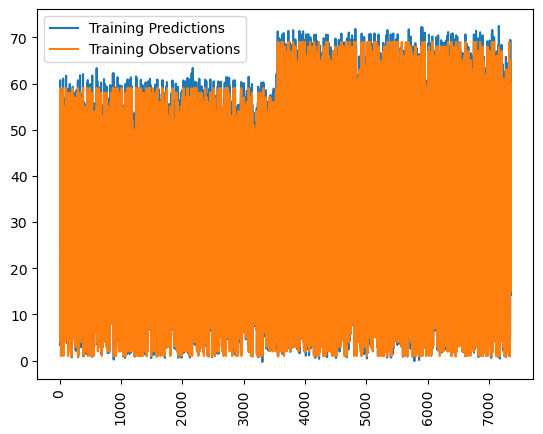

In [56]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, (train_predictions))
plt.plot(dates_train1, (y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [57]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 119.78713989257812
Val MAE: 8.4708833694458


29/29 [==============================] - 0s 3ms/step


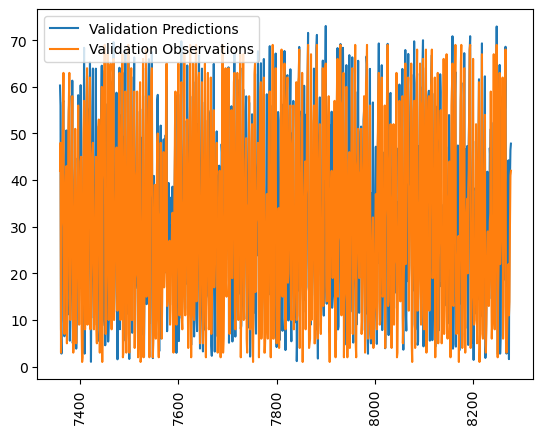

In [58]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, (val_predictions))
plt.plot(dates_val1, (y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [59]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 130.64019775390625
Test MAE: 8.674407958984375


29/29 [==============================] - 0s 3ms/step


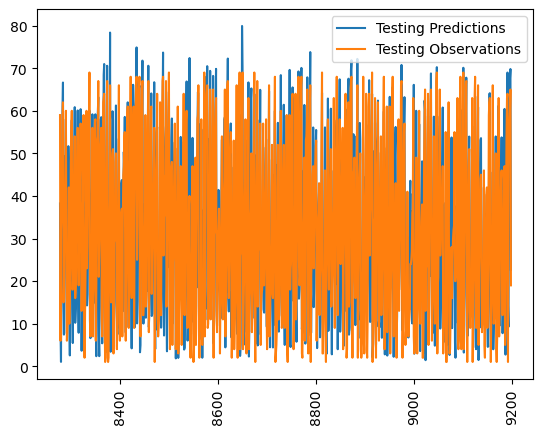

In [60]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1,(test_predictions))
plt.plot(dates_test1, (y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [61]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.6787928157480485


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [64]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 5

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
# initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
# for day in date_range:
#     new_date = initial_date + dt.timedelta(days=day)
#     predicted_dates.append(new_date
#                           )
# 'predictions' contains 7-day forecast
print(predictions)

# for date in predicted_dates:
#     print(date)

1/1 [==============================] - 0s 26ms/step
[22.67003, 55.68775, 63.85178, 63.924854, 65.21196]


ValueError: x and y must have same first dimension, but have shapes (0,) and (5,)

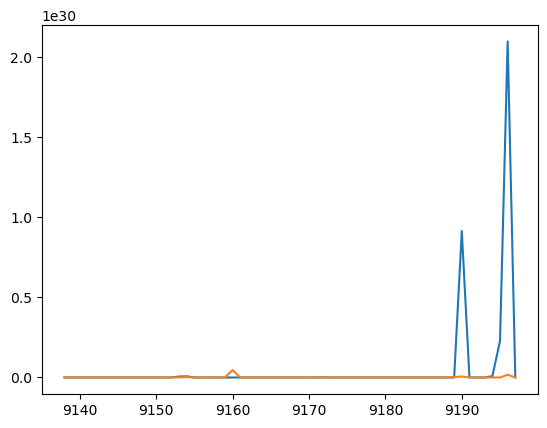

In [65]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test1[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test1[-60:],np.exp(y_test1[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [66]:
# Export model1 to HDF5 file
model.save("pb.h5")

In [72]:
int_predictions = [int(x) for x in predictions]

int_predictions

[22, 55, 63, 63, 65]